In [1]:
from utils import *
import tensorflow as tf

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import np_utils        
from torch.utils.data import TensorDataset 


import os
import sympy as sp
from sympy import exp, sqrt, pi, Integral, Symbol
import time
from scipy.io import savemat


import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
seed_value = 0
set_seed(seed_value)

In [3]:
# make folder to save results
experiment_directory_name = 'binary'
if not os.path.isdir('./'+experiment_directory_name):
    os.mkdir('./'+experiment_directory_name)

In [4]:
# Generate Data

In [5]:
data_n = int(3e6)
sigma=1.0
nb_x_classes = 2
nb_z_classes = 2
transition_prob = 0.1

In [6]:
db = decision_boundary(nb_z_classes)
print(db)

[-1  1]


In [7]:
a = sym_mat(nb_x_classes, transition_prob)
print(a)

[[0.9 0.1]
 [0.1 0.9]]


In [8]:
discrete_x_denoising = source_generator_v2(data_n, a)  
print(discrete_x_denoising[10:20])

[ 1  1  1  1 -1 -1 -1 -1 -1 -1]


In [9]:
noisy_y_denoising = np.round(con_noisy_awgn(discrete_x_denoising,sigma) , 2 ) # upto two decimal point
print(noisy_y_denoising[10:20])

[ 2.49 -1.07  1.43  1.68 -1.64 -1.4  -1.13 -1.3  -1.31 -2.68]


In [10]:
quantized_z_denoising = find_nearest_integer(noisy_y_denoising, nb_z_classes)
print(quantized_z_denoising[10:20])

[ 1 -1  1  1 -1 -1 -1 -1 -1 -1]


In [11]:
print(min(noisy_y_denoising))
print(max(noisy_y_denoising))

-3.77
3.3


In [12]:
print( 'Data length : ', len(discrete_x_denoising) )
error_x_z = error_rate(discrete_x_denoising, quantized_z_denoising)
print('error_rate(x vs z) : ' , error_x_z)

Data length :  300
error_rate(x vs z) :  0.16


# Channel

In [13]:
# induced channel matrix

In [14]:
PI = np.zeros((nb_x_classes,nb_z_classes),dtype=float)
x = Symbol('x')
for i in range(nb_x_classes):
    f = sp.exp(-(x-(db[i]))**2/(2*((sigma)**2)))/(sigma*sp.sqrt(2*sp.pi))
    for j in range(nb_z_classes):
        if j == 0 :
            PI[i][j] = sp.Integral(f, (x, -float('inf'), db[0] + 1 )).doit().evalf()
            
        elif j == nb_z_classes-1:
            PI[i][j] = sp.Integral(f, (x, db[nb_z_classes-1] - 1, float('inf'))).doit().evalf()
            
        else :
            PI[i][j] = sp.Integral(f, (x, db[j]-1, db[j]+1 )).doit().evalf()
    print('proceeding..')
print(PI)

PI_inverse = np.linalg.inv(PI)
print(PI_inverse)

proceeding..
proceeding..
[[0.84134475 0.15865525]
 [0.15865525 0.84134475]]
[[ 1.23239739 -0.23239739]
 [-0.23239739  1.23239739]]


In [15]:
# pdf table

In [16]:
start = - (nb_z_classes-1)*10
print(start)
end = (nb_z_classes-1)*10
print(end)
interval_length = end - start
print(interval_length)

pdf_table = np.zeros((nb_x_classes , interval_length*100),dtype='float64') # interval : 0.01

for i in range(nb_x_classes):
    f = sp.exp(-(x-(db[i]))**2/(2*((sigma)**2)))/(sigma*sp.sqrt(2*sp.pi))
    f_ = f.evalf()
    
    for j in range(interval_length*100) :
        pdf_table[i][j] = f_.subs(x, start+(j)/100) # x에 0.00~9.99대입 
        
    print('proceeding..')
print(pdf_table.shape)
print(pdf_table)

-10
10
20
proceeding..
proceeding..
(2, 2000)
[[1.02797736e-18 1.12473015e-18 1.23046622e-18 ... 2.94588411e-27
  2.63968338e-27 2.36507321e-27]
 [2.11881925e-27 2.36507321e-27 2.63968338e-27 ... 1.34600795e-18
  1.23046622e-18 1.12473015e-18]]


In [17]:
print(min(noisy_y_denoising))
print(max(noisy_y_denoising))
print('Range :',start, -start)

-3.77
3.3
Range : -10 10


In [18]:
np.set_printoptions(linewidth=180)
print('PI :')
print(PI)

print('pdf_table :')
print(pdf_table)

PI :
[[0.84134475 0.15865525]
 [0.15865525 0.84134475]]
pdf_table :
[[1.02797736e-18 1.12473015e-18 1.23046622e-18 ... 2.94588411e-27 2.63968338e-27 2.36507321e-27]
 [2.11881925e-27 2.36507321e-27 2.63968338e-27 ... 1.34600795e-18 1.23046622e-18 1.12473015e-18]]


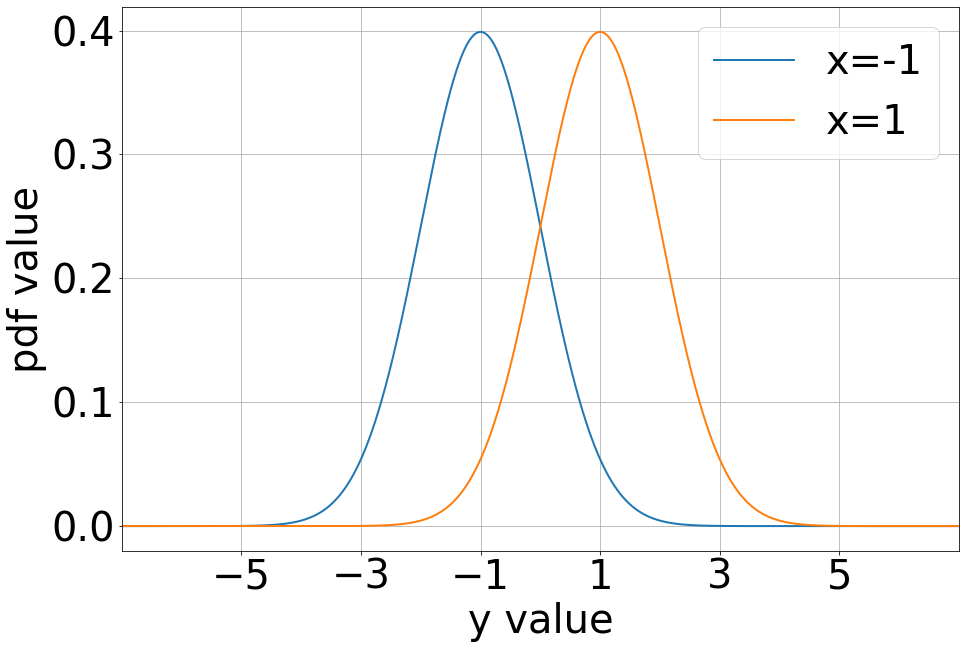

In [19]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True 
plt.rcParams['font.size'] = 40

x = np.arange(start,end,0.01) # -36.00 ~ 35.99 까지 ~~

y_0 = pdf_table[0]
y_1 = pdf_table[1]

plt.plot(x,y_0,label='x=-1') # A bar chart
plt.plot(x,y_1,label='x=1') # A bar chart


#plt.title("pdf table made by picking points ")
plt.xlabel('y value')
plt.ylabel('pdf value')
plt.xticks([-5,-3,-1,1,3,5])
plt.legend(loc='upper right')
plt.xlim(-6+db[0],6+db[nb_z_classes-1])
plt.savefig("./"+experiment_directory_name+"/binary_pdf_table_line.png", dpi = 100)

plt.show()


In [20]:
file_model = 'Gen-CUDE'
    
f = open('./'+experiment_directory_name+'/result_'+file_model+'.txt', 'w') 
f.flush()
f.flush()
f.close()   

In [21]:
batch_size = 1000
epochs = 10

In [22]:
loss_matrix = np.int_(np.ones((nb_x_classes, nb_x_classes)) - np.eye(nb_x_classes))
print(loss_matrix)

z=transform_to_narrow(quantized_z_denoising,nb_z_classes)
Z=np_utils.to_categorical(  z, nb_z_classes ,dtype=np.int32)

[[0 1]
 [1 0]]


In [23]:
k_set = []
error_set = []
time_set = []

for k in [1,2,3,5,8,10,15,20,30,50]:
    print('k',k)
    
    start_time = time.time()  
    ###################################################################################
    train_x = input_context_without_middle_symbol(noisy_y_denoising, k)
    train_y = Z[k:len(Z)-k,]
   

    y_middle = middle_y(noisy_y_denoising,k) 
    pdf_vector = p_vector_from_wide_pdf_table(y_middle, pdf_table, nb_x_classes, end)
    
    
    
    
    #----------------------------Neural Net model------------------------------#
    #inputs = layers.Input(shape = (2 * k * nb_z_classes,))  # one hot
    inputs = layers.Input(shape = (2 * k,))  # not one hot
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(inputs)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(200, kernel_initializer = 'he_normal')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(nb_z_classes , kernel_initializer = 'he_normal')(layer)
    outputs = layers.Activation('softmax')(layer)
    model = models.Model(inputs = inputs, outputs = outputs)
    #--------------------------------------------------------------------------#
    
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam)


    
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size,
                     verbose=0, validation_data=(train_x,train_y), shuffle=True)

    
    pred_prob = model.predict(train_x, batch_size = batch_size, verbose = 0)
    
    pred_prob_u_0 = pred_prob.dot(PI_inverse)
    new_target = pred_prob_u_0 * pdf_vector    
    denoised_seq = np.argmin(new_target.dot(loss_matrix),axis=1) 
    
    x_nn_hat_sub= transform_to_wide(denoised_seq, nb_x_classes)
    x_hat=np.hstack((quantized_z_denoising[0:k],x_nn_hat_sub,quantized_z_denoising[data_n - k:data_n]))
    ###############################################################################################
    
    duration = time.time() - start_time
    print("time(s)):", duration )  
    
    error_x_hat = error_rate(discrete_x_denoising,x_hat)
    print('x_hat_error : ', error_x_hat)

    
    ################################# save result ################################################ 
    f = open('./'+experiment_directory_name+'/result_'+file_model+'.txt', 'a')
    f.flush()
    PRINT(f, 'window size k : %d'%k)
    PRINT(f, 'time(s) : %f'%duration)
    f.flush()
    PRINT(f, 'x_hat_error_rate : %f'%error_x_hat)
    PRINT(f, '')

    f.flush()
    f.close()
    
    
    k_set.append(k)
    time_set.append(duration)
    error_set.append(error_x_hat)

W0601 11:50:38.581630 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0601 11:50:38.583102 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0601 11:50:38.586367 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0601 11:50:38.686606 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0601 11:50:38.694404

k 1


W0601 11:50:38.808760 139750555805440 deprecation.py:323] From /compuworks/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0601 11:50:38.895748 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0601 11:50:39.127517 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0601 11:50:39.396844 139750555805440 module_wrapper.py:139] From /compuworks/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Sessi

time(s)): 2.801053047180176
x_hat_error :  0.12
2020-06-01 11:50:41.378118	window size k : 1
2020-06-01 11:50:41.378195	time(s) : 2.801053
2020-06-01 11:50:41.378485	x_hat_error_rate : 0.120000
2020-06-01 11:50:41.378516	
k 2
time(s)): 1.5087611675262451
x_hat_error :  0.12333333333333334
2020-06-01 11:50:42.889350	window size k : 2
2020-06-01 11:50:42.889461	time(s) : 1.508761
2020-06-01 11:50:42.889779	x_hat_error_rate : 0.123333
2020-06-01 11:50:42.889817	
k 3
time(s)): 1.7775640487670898
x_hat_error :  0.13
2020-06-01 11:50:44.669403	window size k : 3
2020-06-01 11:50:44.669556	time(s) : 1.777564
2020-06-01 11:50:44.669952	x_hat_error_rate : 0.130000
2020-06-01 11:50:44.670240	
k 5
time(s)): 2.234527349472046
x_hat_error :  0.12666666666666668
2020-06-01 11:50:46.906658	window size k : 5
2020-06-01 11:50:46.906733	time(s) : 2.234527
2020-06-01 11:50:46.907023	x_hat_error_rate : 0.126667
2020-06-01 11:50:46.907083	
k 8
time(s)): 2.564574718475342
x_hat_error :  0.14333333333333334
2

In [24]:
saving_list = {'window_size_k':k_set, 'time':time_set, 'error_rate':error_set, 'error_x_z':error_x_z}
saving_list = dict(saving_list)
savemat('./'+experiment_directory_name+'/result_'+file_model+'.mat', saving_list)